# Examen Segundo Parcial 
### Laboratorio de Aprendizaje Estadístico

José Armando Melchor Soto

--- 




### Librerías: 

In [551]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn import discriminant_analysis, neighbors
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

warnings.simplefilter(action='ignore', category=FutureWarning)


### Dataset : 
Recursos Humanos

In [552]:
df= pd.read_csv('hr_role.csv')

---

### Visualización del Dataset

In [553]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


### Explicación de las variables

---

#### Se busca predecir si está satisfecho

In [554]:
df['is_satisfied']

0        True
1       False
2       False
3       False
4       False
        ...  
1465     True
1466    False
1467    False
1468    False
1469    False
Name: is_satisfied, Length: 1470, dtype: bool

In [555]:
target= 'is_satisfied'
y= df[target]

#### Dummies

In [556]:
df= pd.get_dummies(df, drop_first=True)

#### NaN's

In [557]:
pd.DataFrame(df.isnull().sum()).T

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,MonthlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [558]:
df.isna().sum()

Age                                  0
DailyRate                            0
DistanceFromHome                     0
Education                            0
EnvironmentSatisfaction              0
HourlyRate                           0
JobInvolvement                       0
JobLevel                             0
MonthlyIncome                        0
MonthlyRate                          0
NumCompaniesWorked                   0
PercentSalaryHike                    0
PerformanceRating                    0
RelationshipSatisfaction             0
StandardHours                        0
StockOptionLevel                     0
TotalWorkingYears                    0
TrainingTimesLastYear                0
WorkLifeBalance                      0
YearsAtCompany                       0
YearsInCurrentRole                   0
YearsSinceLastPromotion              0
YearsWithCurrManager                 0
is_satisfied                         0
Attrition_Yes                        0
BusinessTravel_Travel_Fre

Ninguna Variable tiene NaN's , así que podemos continuar

#### Modelo

Se pide que el modelo tenga: 

test set: 20%
random_state: 42



#### Función Calibración 

In [559]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

#### Feature Engineering

In [560]:

#Tiempo
df['Tiempo en la empresa'] = df['YearsAtCompany'] / (df['YearsInCurrentRole']+1)
df['Tiempo en el puesto'] = df['YearsInCurrentRole'] / (df['YearsSinceLastPromotion']+1)
df['Tiempo empresa/experencia']= df['YearsAtCompany'] / (df['TotalWorkingYears']+1)
df['Tiempo empresa/edad']= df['YearsAtCompany'] / df['Age'] 
df['Tiempo en el puesto/edad']= df['YearsInCurrentRole'] / df['Age']

#Ingresos
df['Ingreso por hora']= df['HourlyRate'] / df['DailyRate']
df['Ingreso por mes']= df['MonthlyRate'] / df['DailyRate']


#### Correlación con la variable

In [561]:
df.corr()["is_satisfied"].sort_values(ascending=False)

is_satisfied                         1.000000
EducationField_Life Sciences         0.044076
PercentSalaryHike                    0.042461
Gender_Male                          0.040752
OverTime_Yes                         0.039452
JobRole_Sales Executive              0.036071
PerformanceRating                    0.034319
MaritalStatus_Single                 0.032247
Department_Sales                     0.024711
BusinessTravel_Travel_Frequently     0.024431
StockOptionLevel                     0.023456
Tiempo empresa/experencia            0.018817
EnvironmentSatisfaction              0.017072
Tiempo en la empresa                 0.015242
JobRole_Research Scientist           0.014072
TrainingTimesLastYear                0.010379
EducationField_Other                 0.008929
Tiempo en el puesto/edad             0.007047
JobRole_Manager                      0.006649
EducationField_Marketing             0.006395
Tiempo empresa/edad                  0.006304
DailyRate                         

In [562]:
df.drop(columns=['StandardHours','DailyRate','JobRole_Laboratory Technician', 'JobRole_Laboratory Technician',
                 'MonthlyIncome', 'YearsInCurrentRole', 'YearsAtCompany', 'RelationshipSatisfaction','JobRole_Manufacturing Director',
                 'HourlyRate', 'NumCompaniesWorked','Attrition_Yes'], inplace=True)


In [563]:
df.corr()["is_satisfied"].sort_values(ascending=False)

is_satisfied                         1.000000
EducationField_Life Sciences         0.044076
PercentSalaryHike                    0.042461
Gender_Male                          0.040752
OverTime_Yes                         0.039452
JobRole_Sales Executive              0.036071
PerformanceRating                    0.034319
MaritalStatus_Single                 0.032247
Department_Sales                     0.024711
BusinessTravel_Travel_Frequently     0.024431
StockOptionLevel                     0.023456
Tiempo empresa/experencia            0.018817
EnvironmentSatisfaction              0.017072
Tiempo en la empresa                 0.015242
JobRole_Research Scientist           0.014072
TrainingTimesLastYear                0.010379
EducationField_Other                 0.008929
Tiempo en el puesto/edad             0.007047
JobRole_Manager                      0.006649
EducationField_Marketing             0.006395
Tiempo empresa/edad                  0.006304
JobLevel                          

#### Regresión Logística

In [564]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = linear_model.LogisticRegression().fit(X_train, y_train)

probabilidades_modelo1 = model.predict_proba(X_test)[:, 1]

c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


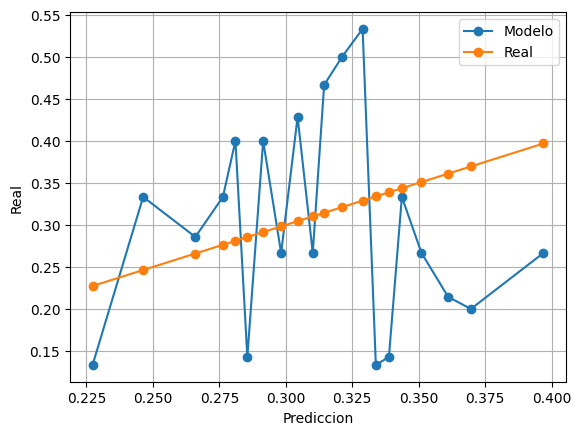

In [565]:
calibracion(probabilidades_modelo1, y_test, 20)


##### Polinomica 2

In [566]:
pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('poly_features', PolynomialFeatures(degree=2)),
     ('model', linear_model.LogisticRegression(penalty='l2'))
])

pipeline.fit(X_train, y_train)
probabilidades_modelo2 = pipeline.predict_proba(X_test)[:, 1]

c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


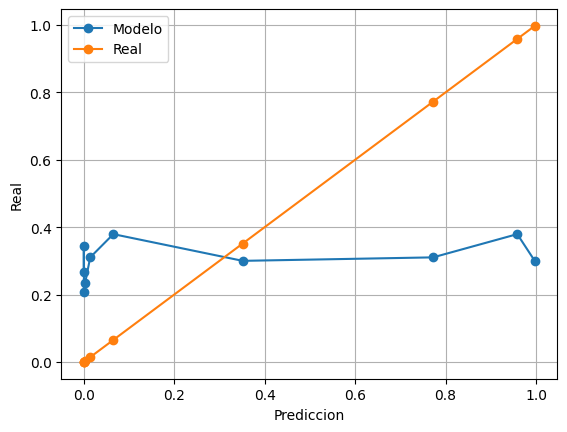

In [567]:
calibracion(probabilidades_modelo2, y_test, 10)

##### Polinomica 3

In [568]:
pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('poly_features', PolynomialFeatures(degree=3)),
     ('model', linear_model.LogisticRegression(penalty='l2'))
])

pipeline.fit(X_train, y_train)
probabilidades_modelo3 = pipeline.predict_proba(X_test)[:, 1]

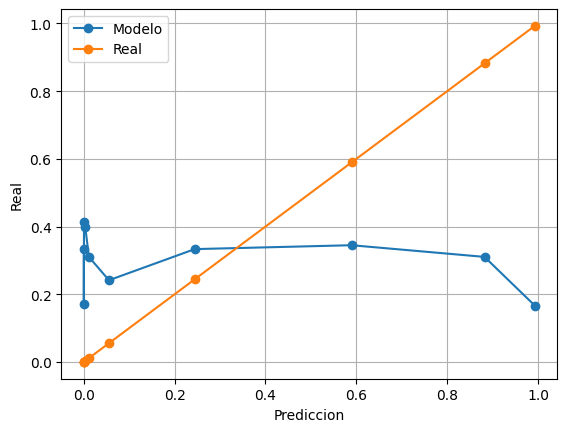

In [569]:
calibracion(probabilidades_modelo3, y_test, 10)

##### Analisis de Discriminante Lineal

In [570]:
pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('model', discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)
probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:, 1]

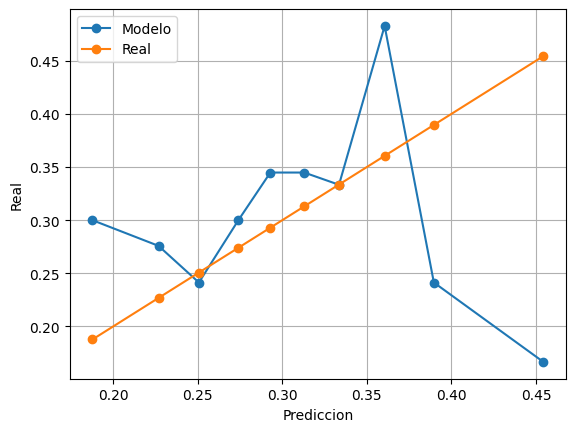

In [571]:
calibracion(probabilidades_modelo_disc, y_test, 10)

In [572]:
juntos = pd.DataFrame({
     'real': y_test,
     'logistica1': probabilidades_modelo1,
     'logistica2': probabilidades_modelo2,
     'logistica3': probabilidades_modelo3,
     'probabilidades_disc': probabilidades_modelo_disc
})

juntos.head()

,real,logistica1,logistica2,logistica3,probabilidades_disc
1041,False,0.306293,0.192157,0.907337,0.355219
184,False,0.215004,0.975459,0.930533,0.206392
1222,False,0.347033,0.000002,0.000007,0.312242
67,False,0.358721,0.017442,0.085634,0.317065
220,False,0.311244,0.014359,0.383091,0.383259


In [573]:
bins = 10
juntos['bins_log1'] = pd.qcut(juntos['logistica1'], bins, labels=False) + 1
juntos['bins_log2'] = pd.qcut(juntos['logistica2'], bins, labels=False) + 1
juntos['bins_log3'] = pd.qcut(juntos['logistica3'], bins, labels=False) + 1
juntos['bins_disc'] = pd.qcut(juntos['probabilidades_disc'], bins, labels=False) + 1

# Agrupaciones
grouped_log1 = juntos.groupby('bins_log1').mean()
grouped_log2 = juntos.groupby('bins_log2').mean()
grouped_log3 = juntos.groupby('bins_log3').mean()
grouped_disc = juntos.groupby('bins_disc').mean()

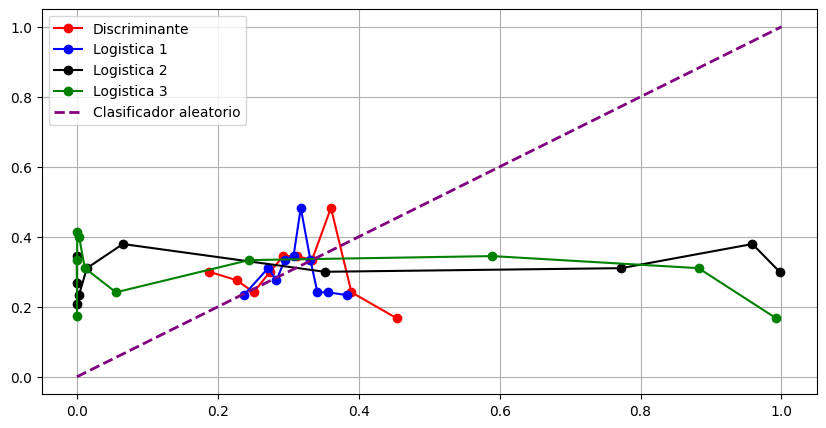

In [574]:
# Define a list of colors
colors = ['blue', 'black', 'green', 'red', 'purple']

plt.figure(figsize=(10, 5))
plt.plot(grouped_disc.probabilidades_disc, grouped_disc.real, marker='o', label='Discriminante', color=colors[3])
plt.plot(grouped_log1.logistica1, grouped_log1.real, marker='o', label='Logistica 1', color=colors[0])
plt.plot(grouped_log2.logistica2, grouped_log2.real, marker='o', label='Logistica 2', color=colors[1])
plt.plot(grouped_log3.logistica3, grouped_log3.real, marker='o', label='Logistica 3', color=colors[2])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Clasificador aleatorio', color=colors[-1])
plt.legend()
plt.grid()

In [575]:
print('Modelo Logístico: ',log_loss(y_pred=juntos.logistica1, y_true=juntos.real))
print('Modelo Polinomico 2: ',log_loss(y_pred=juntos.logistica2, y_true=juntos.real))
print('Modelo Polinomico 3: ',log_loss(y_pred=juntos.logistica3, y_true=juntos.real))
print('Modelo discriminante: ',log_loss(y_pred=juntos.probabilidades_disc, y_true=juntos.real))

Modelo Logístico:  0.6184321109566772
Modelo Polinomico 2:  2.664012974197643
Modelo Polinomico 3:  2.520401119043148
Modelo discriminante:  0.6306100012212847


#### Histograma, roc AUC y AUC

##### Regresión Logistica

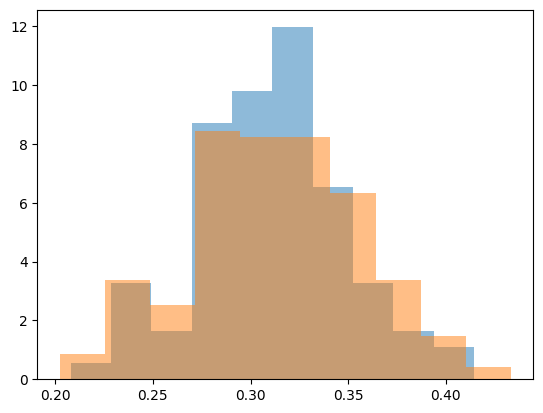

In [576]:
plt.hist(juntos[juntos.real == 1].logistica1, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].logistica1, density=True, alpha=0.5, bins=10)
plt.show()

AUC:  0.4855028775006851


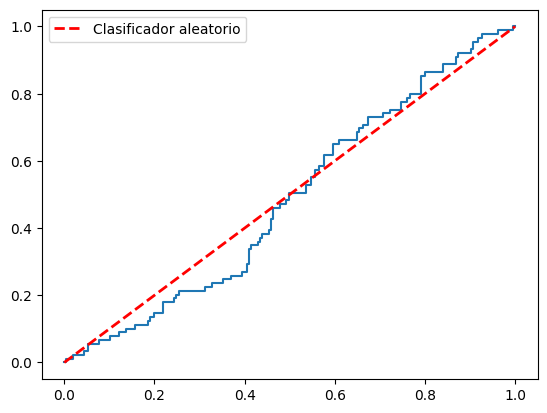

In [577]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo1, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()
print('AUC: ',roc_auc_score(y_score= probabilidades_modelo1, y_true=y_test))

##### Polinomica 2

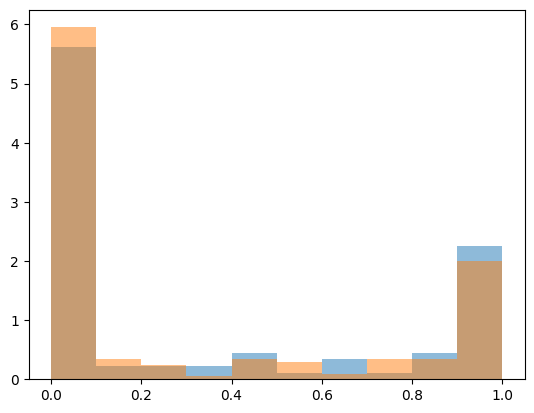

In [578]:
plt.hist(juntos[juntos.real == 1].logistica2, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].logistica2, density=True, alpha=0.5, bins=10)
plt.show()

AUC:  0.5280898876404494


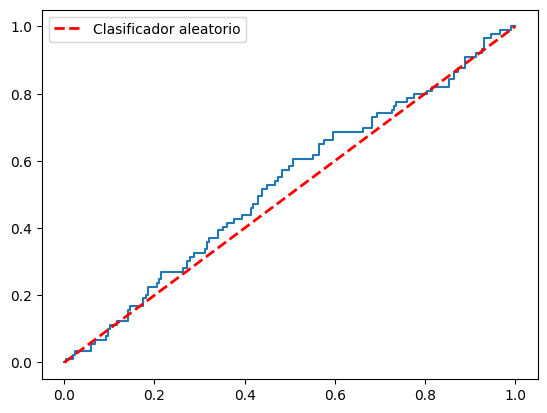

In [579]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo2, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()

print('AUC: ',roc_auc_score(y_score= probabilidades_modelo2, y_true=y_test))

##### Polinomial  Grado 3

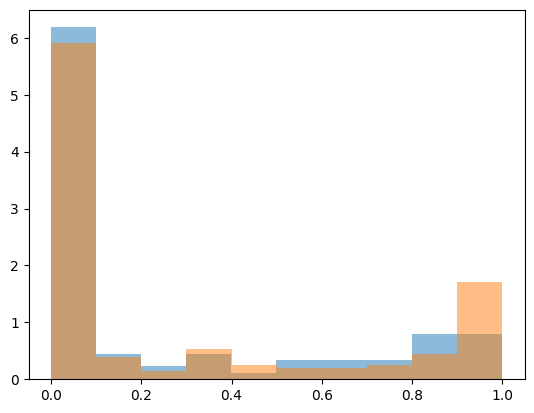

In [580]:
plt.hist(juntos[juntos.real == 1].logistica3, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].logistica3, density=True, alpha=0.5, bins=10)
plt.show()

AUC:  0.47147163606467524


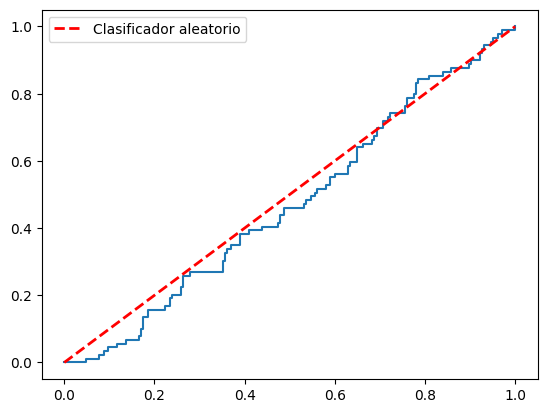

In [581]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo3, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()
print('AUC: ',roc_auc_score(y_score= probabilidades_modelo3, y_true=y_test))

##### Discriminante Lineal

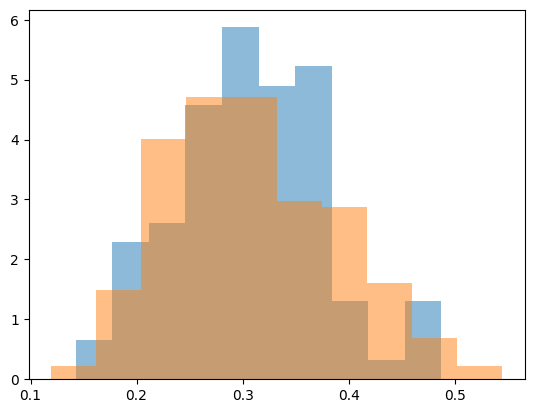

In [582]:
plt.hist(juntos[juntos.real == 1].probabilidades_disc, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].probabilidades_disc, density=True, alpha=0.5, bins=10)
plt.show()

AUC:  0.4964099753357084


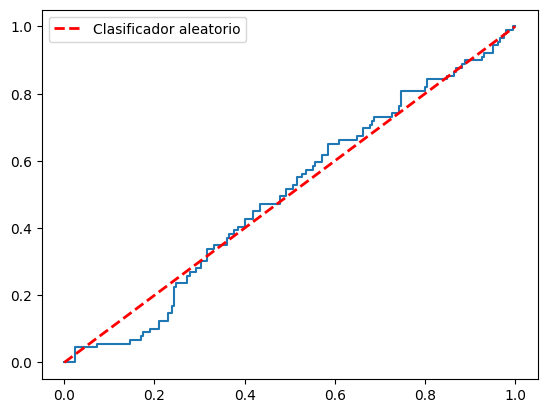

In [583]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo_disc, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()
print('AUC: ',roc_auc_score(y_score= probabilidades_modelo_disc, y_true=y_test))

#### KNN Clasificador

Optimo nn: 62
AUC: 0.5373801041381201


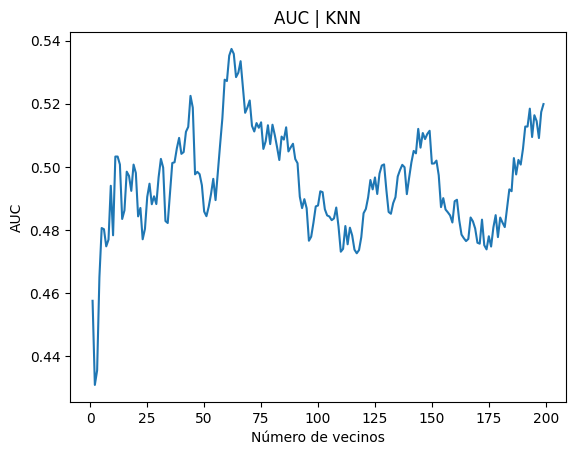

In [584]:
vecinos = []
auc = []
for i in range(1, 200):
    model = neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    probabilidades = model.predict_proba(X_test)[:, 1]
    vecinos.append(i)
    auc.append(roc_auc_score(y_score=probabilidades, y_true=y_test))

mejor_vecino = vecinos[auc.index(max(auc))]
mejor_auc = max(auc)

plt.plot(vecinos, auc)
plt.xlabel("Número de vecinos")
plt.ylabel("AUC")
plt.title("AUC | KNN")

print(f"Optimo nn: {mejor_vecino}")
print(f"AUC: {mejor_auc}")

In [585]:
# Definir pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización de datos
    ('knn', KNeighborsClassifier())  
])

params_grid = {
    'knn__n_neighbors': range(1, 30), 
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'] 
}

In [586]:
grid_search= GridSearchCV(estimator=pipeline, param_grid=params_grid, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': range(1, 30),
                         'knn__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [587]:
grid_search.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 29, 'knn__weights': 'uniform'}

In [588]:
prob_knn_grid= grid_search.best_estimator_.predict_proba(X_test)[:,1]
roc_auc_score(y_true=y_test, y_score=prob_knn_grid)

np.float64(0.47988489997259526)

In [589]:
grid_search.cv_results_

{'mean_fit_time': array([0.00736761, 0.0114247 , 0.01106604, 0.01092569, 0.01200445,
        0.01217794, 0.01514451, 0.01627604, 0.01228825, 0.01070674,
        0.01006484, 0.03236095, 0.01263452, 0.02030373, 0.01988896,
        0.01582615, 0.01559806, 0.01506209, 0.01507052, 0.01617686,
        0.01700354, 0.01421086, 0.01239848, 0.01307305, 0.01344514,
        0.01551898, 0.01467292, 0.01539   , 0.01470629, 0.01488876,
        0.01594782, 0.01599177, 0.01503452, 0.01399334, 0.01510525,
        0.01353335, 0.01740885, 0.01482606, 0.0279932 , 0.02144376,
        0.0144306 , 0.01446994, 0.01474261, 0.01603238, 0.01684451,
        0.01508999, 0.01353033, 0.01402315, 0.01704105, 0.01617066,
        0.0156432 , 0.01558137, 0.01545715, 0.01708547, 0.01246516,
        0.01286554, 0.01540907, 0.01269436, 0.01449656, 0.01157546,
        0.01712688, 0.01467315, 0.01276922, 0.0146838 , 0.01333404,
        0.01246246, 0.012127  , 0.01482519, 0.01625156, 0.01400208,
        0.01487311, 0.01368244,

#### Utilizando random search

In [590]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=params_grid, n_iter=15, cv=3, n_jobs=-1, scoring='roc_auc')
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'knn__metric': ['euclidean',
                                                        'manhattan'],
                                        'knn__n_neighbors': range(1, 30),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='roc_auc')

In [591]:
random_search.best_params_

{'knn__weights': 'uniform', 'knn__n_neighbors': 25, 'knn__metric': 'manhattan'}

In [592]:
random_knn= random_search.best_estimator_.predict_proba(X_test)[:,1]
print('AUC:', roc_auc_score(y_score= random_knn, y_true=y_test))

AUC: 0.4744313510550835


#### Usando Grid Search

In [593]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # grado se definirá en grid search
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, random_state=42))
])
pipeline

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(max_iter=10000, random_state=42))])

In [594]:
params_grid= {
    'poly__degree': [1, 2, 3],
    'logreg__C': ['l2', None],
    'logreg__C': [0.01,0.1,1]
}

log_reg_grid= GridSearchCV(estimator=pipeline, param_grid=params_grid, cv=5, n_jobs=-1, scoring='roc_auc')
log_reg_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01, 0.1, 1],
                         'poly__degree': [1, 2, 3]},
             scoring='roc_auc')

In [595]:
log_reg_grid.best_params_

{'logreg__C': 0.01, 'poly__degree': 3}

In [596]:
probabilities_log_reg_grid = log_reg_grid.best_estimator_.predict_proba(X_test)[:,1]
print('AUC:', roc_auc_score(y_score=probabilities_log_reg_grid, y_true=y_test))

AUC: 0.49416278432447236


#### Red neuronal

In [597]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier())
])

# Params grid
params_grid = {
    'nn__hidden_layer_sizes': [(100, 100), (100, 100, 100), (100, 100, 100)],
    'nn__activation': ['tanh', 'relu', 'logistic'],
    'nn__alpha': [0.01, 0.001],  # Avoid duplicate values
}

# Fit
grid_nn = GridSearchCV(estimator=pipeline, param_grid=params_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_nn.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nn', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'nn__activation': ['tanh', 'relu', 'logistic'],
                         'nn__alpha': [0.01, 0.001],
                         'nn__hidden_layer_sizes': [(100, 100), (100, 100, 100),
                                                    (100, 100, 100)]},
             scoring='roc_auc')

In [598]:
grid_nn.best_params_

{'nn__activation': 'relu',
 'nn__alpha': 0.001,
 'nn__hidden_layer_sizes': (100, 100, 100)}

In [599]:
y_pred_prob = grid_nn.best_estimator_.predict_proba(X_test)[:, 1]  # Seleccionamos la columna de probabilidades positivas

# Calcular AUC
auc = roc_auc_score(y_test, y_pred_prob)

# Mostrar el AUC
print("AUC:", auc)

AUC: 0.4867086873115922
